# **Импорт библиотек и модулей**

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Input
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import io
from PIL import Image
import ipywidgets as widgets
from IPython.display import display, clear_output

Found 7624 files belonging to 53 classes.
Found 265 files belonging to 53 classes.
Found 265 files belonging to 53 classes.
Количество обучающих(train) пакетов: 212
Количество проверочных(valid) пакетов: 8
Количество тестовых(test) пакетов: 265
Получение словаря соответствий:
0: ace of clubs
1: ace of diamonds
2: ace of hearts
3: ace of spades
4: eight of clubs
5: eight of diamonds
6: eight of hearts
7: eight of spades
8: five of clubs
9: five of diamonds
10: five of hearts
11: five of spades
12: four of clubs
13: four of diamonds
14: four of hearts
15: four of spades
16: jack of clubs
17: jack of diamonds
18: jack of hearts
19: jack of spades
20: joker
21: king of clubs
22: king of diamonds
23: king of hearts
24: king of spades
25: nine of clubs
26: nine of diamonds
27: nine of hearts
28: nine of spades
29: queen of clubs
30: queen of diamonds
31: queen of hearts
32: queen of spades
33: seven of clubs
34: seven of diamonds
35: seven of hearts
36: seven of spades
37: six of clubs
38: s

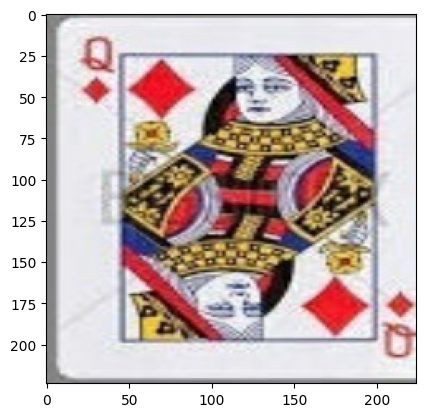

In [7]:
# Основные параметры
root = "/kaggle/input/cards-image-datasetclassification"  # Корневой путь к готовым данным с kaggle
image_size = (224, 224)  # Размер изображения, к которому они будут приведены перед подачей в модель
batch_size = 36
epochs = 12  # Количество эпох для обучения

# Определяем функции для нормализации изображений
def preprocess_image(image, label, num_classes):
    image = tf.image.resize(image, image_size)
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(label, num_classes)  # Преобразование меток в формат one-hot encoded
    return image, label

# Функция для получения DataLoader-ов для тренировочного, валидного и тестового датасетов
def get_dataloaders(root, batch_size):
    train_dir = os.path.join(root, 'train')
    valid_dir = os.path.join(root, 'valid')
    test_dir = os.path.join(root, 'test')

    train_dataset = image_dataset_from_directory(train_dir,
                                                 shuffle=True,
                                                 batch_size=batch_size,
                                                 image_size=image_size)

    valid_dataset = image_dataset_from_directory(valid_dir,
                                                 shuffle=False,
                                                 batch_size=batch_size,
                                                 image_size=image_size)

    test_dataset = image_dataset_from_directory(test_dir,
                                                shuffle=False,
                                                batch_size=1,
                                                image_size=image_size)

    class_names = train_dataset.class_names
    num_classes = len(class_names)

    train_dataset = train_dataset.map(lambda image, label: preprocess_image(image, label, num_classes))
    valid_dataset = valid_dataset.map(lambda image, label: preprocess_image(image, label, num_classes))
    test_dataset = test_dataset.map(lambda image, label: preprocess_image(image, label, num_classes))

    return train_dataset, valid_dataset, test_dataset, class_names

# Получаем DataLoader-ы и список классов
train_dataset, valid_dataset, test_dataset, class_names = get_dataloaders(root=root, batch_size=batch_size)

# Печать информации о DataLoader-ах
print(f'Количество обучающих(train) пакетов: {len(train_dataset)}')
print(f'Количество проверочных(valid) пакетов: {len(valid_dataset)}')
print(f'Количество тестовых(test) пакетов: {len(test_dataset)}')

# Получение словаря соответствий target -> class
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
print('Получение словаря соответствий:')
for class_name, target in class_to_idx.items():
    print(f'{target}: {class_name}')

# Пример получения изображения и метки
for image, label in train_dataset.take(1):
    print(f'Знак: {label[0].numpy()}')
    plt.imshow(image[0].numpy())
    plt.show()


# **Создание модели**

In [8]:
# Создание модели
model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Добавление Dropout слоя для предотвращения переобучения
    Dense(len(class_names), activation='softmax')
])

model.compile(loss="categorical_crossentropy", optimizer="SGD", metrics=["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 53)             │         6,837 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,175,797 (42.63 MB)

 Trainable params: 11,175,797 (42.63 MB)

 Non-trainable params: 0 (0.00 B)

# **Обучение модели**

Epoch 1/12
212/212 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.0257 - loss: 3.9710 - val_accuracy: 0.0453 - val_loss: 3.9010
Epoch 2/12
212/212 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.0521 - loss: 3.8642 - val_accuracy: 0.1585 - val_loss: 3.3987
Epoch 3/12
212/212 ━━━━━━━━━━━━━━━━━━━━ 384s 2s/step - accuracy: 0.1354 - loss: 3.4489 - val_accuracy: 0.3283 - val_loss: 2.4564
Epoch 4/12
212/212 ━━━━━━━━━━━━━━━━━━━━ 444s 2s/step - accuracy: 0.2606 - loss: 2.8395 - val_accuracy: 0.4792 - val_loss: 1.8077
Epoch 5/12
212/212 ━━━━━━━━━━━━━━━━━━━━ 444s 2s/step - accuracy: 0.3511 - loss: 2.4592 - val_accuracy: 0.5094 - val_loss: 1.5887
Epoch 6/12
212/212 ━━━━━━━━━━━━━━━━━━━━ 390s 2s/step - accuracy: 0.4008 - loss: 2.2132 - val_accuracy: 0.6151 - val_loss: 1.4254
Epoch 7/12
212/212 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.4570 - loss: 1.9846 - val_accuracy: 0.6264 - val_loss: 1.3063
Epoch 8/12
212/212 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - accuracy: 0.5096 - loss: 1.7860 - val_accu

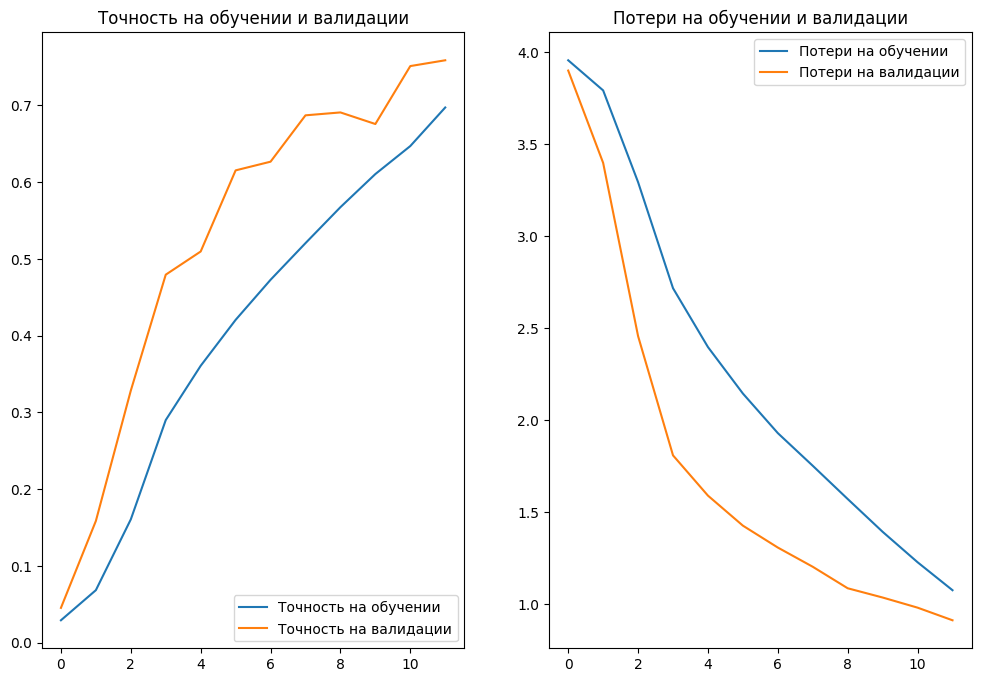

Модель сохранена по пути: /kaggle/working/card_classification_model.h5


In [9]:
# Очистка сессии TensorFlow перед обучением модели
K.clear_session()

# Обучение модели
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs
)

# Оценка модели на тестовом наборе данных
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Тестовая потеря: {test_loss}')
print(f'Тестовая точность: {test_acc}')

# Построение графиков потерь и точности
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Точность на обучении')
plt.plot(epochs_range, val_acc, label='Точность на валидации')
plt.legend(loc='lower right')
plt.title('Точность на обучении и валидации')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Потери на обучении')
plt.plot(epochs_range, val_loss, label='Потери на валидации')
plt.legend(loc='upper right')
plt.title('Потери на обучении и валидации')
plt.show()

# Сохранение модели в формате .h5
model_save_path = '/kaggle/working/card_classification_model.h5'
model.save(model_save_path)
print(f"Модель сохранена по пути: {model_save_path}")